In [3]:
# imports
import sys, os
sys.path.append(os.getcwd()+'/code')
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import Algorithms
from data_streamer import Streamer, MultiStreamer

In [4]:
# constants
train_data_file=os.getcwd() + '/data/train_mnist_normalized.csv'
validation_data_file=os.getcwd() + '/data/test_mnist_normalized.csv'
assert os.path.isfile(train_data_file)
k = 100 # dimensionality of representations
d = 784 # dimensionality of input
learning_rate = 1 # initial learning rate
validation_freq = 1000 # how many training steps in between validations

In [12]:
# data streamer and algorithm
train_stream = Streamer(train_data_file).get_stream()
algorithm=Algorithms.oja({'d': d, 'k': k, 'learning_rate': learning_rate, 'mean_center': 0.0})
# load validation data at once to make validation faster
validation_data=[]
for point in Streamer(validation_data_file).get_stream():
    validation_data.append(point)
validation_data=np.stack(validation_data,axis=0)
# do PCA on the validation as a lower bound
centered_data=validation_data - np.mean(validation_data,axis=0,keepdims=True)
lambdas,_=np.linalg.eigh(np.matmul(centered_data.T,centered_data))
best_validation_loss=sum(lambdas[:-k])/(centered_data.shape[0]*centered_data.shape[1])

In [6]:
# placeholders for loss
validation_loss, training_loss, min_training_loss = [], [], []
training_batch = []
# main loop
counter=0
for point in train_stream:
    counter+=1
    algorithm.step(point)
    training_batch.append(point)
    if counter%validation_freq==0:
        loss=algorithm.loss(validation_data)
        loss/=(validation_data.shape[0]*validation_data.shape[1])
        validation_loss.append(loss)
        training_batch=np.stack(training_batch,axis=0)
        loss=algorithm.loss(training_batch)
        loss/=(training_batch.shape[0]*training_batch.shape[1])
        training_loss.append(loss)
        # for information, compute the los for the non-stochastic, closed form solution
        # our training loss couldn't be lower than that
        """centered_data=training_batch - np.mean(training_batch,axis=0,keepdims=True)
        lambdas,_=np.linalg.eigh(np.matmul(centered_data.T,centered_data))
        loss=sum(lambdas[:-k])/(training_batch.shape[0]*training_batch.shape[1])
        min_training_loss.append(loss)"""
        training_batch=[]

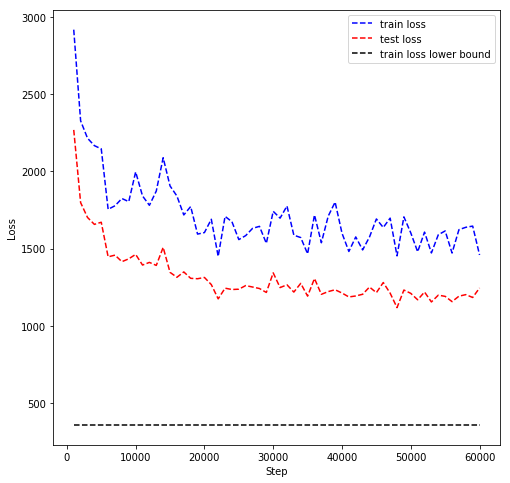

In [13]:
# plot the train and test loss
# the loss is high because the MNIST data is NOT normalized
plt.figure(figsize=(8, 8))
plt.xlabel('Step')
plt.ylabel('Loss')
#plt.yscale('log')
x_scale=[x*validation_freq for x in range(1,len(training_loss)+1)]
plt.plot(x_scale, training_loss, '--b', label='train loss')
plt.plot(x_scale, validation_loss, '--r', label='test loss')
plt.plot(x_scale, [best_validation_loss]*len(training_loss), '--k', label='train loss lower bound')
_ = plt.legend()